# Projet M1 IIA Djibril DAHOUB

## Modèle de détection de pose karaté

In [1]:
# Lybrary importations
import cv2
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
import pandas as pd
import os
import re
from genericpath import exists
import shutil
import json

In [2]:
def extract_images(data_path, interval = 10):
    list_videos = sorted(os.listdir(data_path))
    for vid in list_videos:
        video = data_path+"/"+vid
        print(video)
        cap = cv2.VideoCapture(video)
        if not cap.isOpened():
            print(f"Eror : video opening failed : {video}")
            return None
        
        output_forlder = vid+"Frames"
        if not exists(output_forlder):
            os.makedirs(output_forlder)
        count = 0
        saved_count = 0
        video_running = True

        while video_running : 
            ret, frame = cap.read()
            if not ret:
                break
            if count % interval == 0:
                image_path = os.path.join(output_forlder, f"frame_{saved_count:04d}.jpg")
                success = cv2.imwrite(image_path, frame)  # 📸 Enregistre l'image

                if success:
                    print(f"Image enregistrée : {image_path}")
                else:
                    print(f"Échec de l'enregistrement : {image_path}")
                saved_count += 1
            
            count += 1
        
        cap.release()
        print("Extraction finiched fine, here is the number of frame saved : ", saved_count)

In [3]:
data_path = "kataVids_cuted"
#extract_images(data_path)

In [5]:
# Code From DatumLearning : https://github.com/DatumLearning/Mediapipe-playlist/blob/main/object_detection_image.ipynb
# Get original MediaPipe landmarks from an image
def getLandmarksfromImage(image):
    # Load MediaPipe Pose model
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()

    # Convert image to RGB (MediaPipe accepts RGB images)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform pose estimation
    results = pose.process(image_rgb)

    # Draw pose landmarks on the image
    if results.pose_landmarks:

        landmark_dict = {}

        for i, landmark in enumerate(results.pose_landmarks.landmark):
            landmark_name = mp_pose.PoseLandmark(i).name
            x = landmark.x
            y = landmark.y
            z = landmark.z  # Correctly assign the z value
            visibility = landmark.visibility

            # Add to landmark_dict
            landmark_dict[landmark_name] = (x, y, z, visibility)
            
    return landmark_dict

In [6]:
# Function to detect poses and draw them on the image
def detect_and_draw_pose(image, visibility_threshold=0.5):
    # Load MediaPipe Pose model
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()

    # Convert image to RGB (MediaPipe accepts RGB images)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform pose estimation
    results = pose.process(image_rgb)

    # Draw pose landmarks on the image
    if results.pose_landmarks:
        mp_drawing = mp.solutions.drawing_utils
        annotated_image = image.copy()
        
        landmark_dict = {}

        for i, landmark in enumerate(results.pose_landmarks.landmark):
            landmark_name = mp_pose.PoseLandmark(i).name
            x = int(landmark.x * image.shape[1])
            y = int(landmark.y * image.shape[0])
            visibility = landmark.visibility

            # Add to landmark_dict
            landmark_dict[landmark_name] = (x, y, visibility)

            # Draw on image only if visibility is above the threshold
            if visibility > visibility_threshold:
                # Draw point
                cv2.circle(annotated_image, (x, y), 5, (0, 255, 0), -1)

        # Draw connections
        for connection in mp_pose.POSE_CONNECTIONS:
            start_idx = connection[0]
            end_idx = connection[1]
            if results.pose_landmarks.landmark[start_idx].visibility > visibility_threshold and results.pose_landmarks.landmark[end_idx].visibility > visibility_threshold:
                start_point = (int(results.pose_landmarks.landmark[start_idx].x * image.shape[1]), 
                               int(results.pose_landmarks.landmark[start_idx].y * image.shape[0]))
                end_point = (int(results.pose_landmarks.landmark[end_idx].x * image.shape[1]), 
                             int(results.pose_landmarks.landmark[end_idx].y * image.shape[0]))
                cv2.line(annotated_image, start_point, end_point, (0, 255, 0), 2)

        return annotated_image, landmark_dict
    else:
        return image, None

In [9]:
# Load an example image

image_path = 'Images/ImagesOriginal/frame_0000.jpg'
image = cv2.imread(image_path)
print(image)

[[[10 16 15]
  [10 16 15]
  [10 16 15]
  ...
  [ 5 10  9]
  [ 4  9  8]
  [ 3  8  7]]

 [[ 0  6  5]
  [ 0  6  5]
  [ 0  6  5]
  ...
  [ 7 12 11]
  [ 7 12 11]
  [ 7 12 11]]

 [[ 0  1  0]
  [ 0  1  0]
  [ 0  1  0]
  ...
  [ 0  1  0]
  [ 0  1  0]
  [ 0  1  0]]

 ...

 [[17 25 24]
  [17 25 24]
  [17 25 24]
  ...
  [15 23 22]
  [15 23 22]
  [15 23 22]]

 [[ 4 12 11]
  [ 4 12 11]
  [ 4 12 11]
  ...
  [10 18 17]
  [10 18 17]
  [10 18 17]]

 [[ 0  5  4]
  [ 0  5  4]
  [ 0  5  4]
  ...
  [ 6 14 13]
  [ 6 14 13]
  [ 6 14 13]]]


In [10]:
# Detect and draw pose on the image
annotated_image, pose_landmarks_dict = detect_and_draw_pose(
    image, visibility_threshold=0.6)

I0000 00:00:1742891752.163281   11887 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1742891752.284353   12832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742891752.305512   12832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742891752.331024   12837 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [11]:
# Print pose landmarks with labels
if pose_landmarks_dict:
    for name, (x, y, visibility) in pose_landmarks_dict.items():
        print(f'{name}: ({x}, {y}), visibility: {visibility:.2f}')

NOSE: (161, 86), visibility: 1.00
LEFT_EYE_INNER: (160, 82), visibility: 1.00
LEFT_EYE: (159, 82), visibility: 1.00
LEFT_EYE_OUTER: (159, 82), visibility: 1.00
RIGHT_EYE_INNER: (159, 82), visibility: 1.00
RIGHT_EYE: (158, 81), visibility: 1.00
RIGHT_EYE_OUTER: (156, 81), visibility: 1.00
LEFT_EAR: (154, 83), visibility: 1.00
RIGHT_EAR: (149, 83), visibility: 1.00
MOUTH_LEFT: (159, 91), visibility: 1.00
MOUTH_RIGHT: (158, 90), visibility: 1.00
LEFT_SHOULDER: (157, 110), visibility: 1.00
RIGHT_SHOULDER: (126, 104), visibility: 1.00
LEFT_ELBOW: (174, 133), visibility: 0.88
RIGHT_ELBOW: (105, 128), visibility: 0.99
LEFT_WRIST: (193, 145), visibility: 0.96
RIGHT_WRIST: (128, 137), visibility: 0.98
LEFT_PINKY: (199, 149), visibility: 0.94
RIGHT_PINKY: (133, 140), visibility: 0.95
LEFT_INDEX: (199, 148), visibility: 0.95
RIGHT_INDEX: (136, 138), visibility: 0.94
LEFT_THUMB: (197, 147), visibility: 0.94
RIGHT_THUMB: (135, 138), visibility: 0.90
LEFT_HIP: (148, 162), visibility: 1.00
RIGHT_HIP:

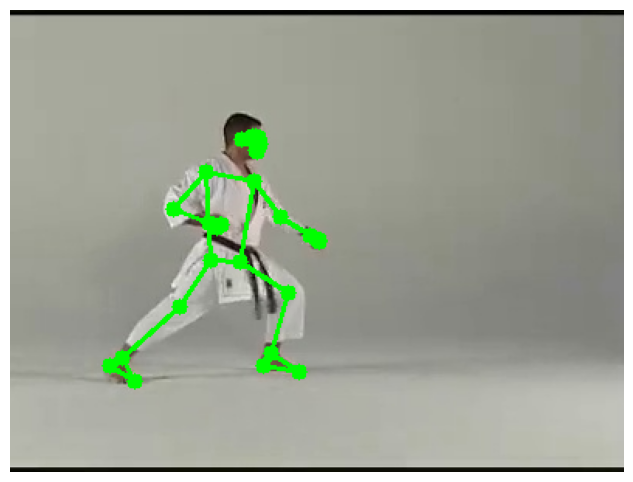

In [12]:
# Display using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [13]:
getLandmarksfromImage(image)

I0000 00:00:1742891814.711559   11887 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1
W0000 00:00:1742891814.832944   13200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742891814.851338   13200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


{'NOSE': (0.40835151076316833,
  0.29164478182792664,
  -0.13277001678943634,
  0.9999597072601318),
 'LEFT_EYE_INNER': (0.40412837266921997,
  0.27585044503211975,
  -0.11172531545162201,
  0.9999176263809204),
 'LEFT_EYE': (0.40353503823280334,
  0.27550259232521057,
  -0.1117725595831871,
  0.999914288520813),
 'LEFT_EYE_OUTER': (0.40281668305397034,
  0.27516940236091614,
  -0.11184313148260117,
  0.9999210834503174),
 'RIGHT_EYE_INNER': (0.4016602635383606,
  0.2755778729915619,
  -0.14838212728500366,
  0.9999446868896484),
 'RIGHT_EYE': (0.39920705556869507,
  0.274935781955719,
  -0.14842592179775238,
  0.9999477863311768),
 'RIGHT_EYE_OUTER': (0.3963913321495056,
  0.27425819635391235,
  -0.14846530556678772,
  0.9999369382858276),
 'LEFT_EAR': (0.3890267610549927,
  0.27984344959259033,
  -0.01281642634421587,
  0.9997732043266296),
 'RIGHT_EAR': (0.37726330757141113,
  0.2789120376110077,
  -0.18232949078083038,
  0.9999246597290039),
 'MOUTH_LEFT': (0.4029655158519745,
  0.